In [2]:
import cv2
import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
x_corners, y_corners = (7, 7)
square_size = 25.4 # mm

In [17]:
def get_img_points(image):
    img_points = []
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_img, (x_corners, y_corners), None)
    if ret is True:
        corners = corners.reshape(-1, 2)
        corners = cv2.cornerSubPix(gray_img, corners,(11,11),(-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        img_points.append(corners)
        return np.array(img_points).reshape(-1, 2)
    
    

def get_my_world_points():
    row = np.arange(x_corners)
    col = np.arange(y_corners)

    xx, yy = np.meshgrid(row, col)
    grid   = np.column_stack([xx.ravel(), yy.ravel()])

    return grid

In [18]:
my_world_points = get_my_world_points()

In [19]:
print(my_world_points)

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [0 1]
 [1 1]
 [2 1]
 [3 1]
 [4 1]
 [5 1]
 [6 1]
 [0 2]
 [1 2]
 [2 2]
 [3 2]
 [4 2]
 [5 2]
 [6 2]
 [0 3]
 [1 3]
 [2 3]
 [3 3]
 [4 3]
 [5 3]
 [6 3]
 [0 4]
 [1 4]
 [2 4]
 [3 4]
 [4 4]
 [5 4]
 [6 4]
 [0 5]
 [1 5]
 [2 5]
 [3 5]
 [4 5]
 [5 5]
 [6 5]
 [0 6]
 [1 6]
 [2 6]
 [3 6]
 [4 6]
 [5 6]
 [6 6]]


In [20]:
img1 = cv2.imread("./Calibration_Imgs/1.png")

img_points_1 = get_img_points(img1)

In [21]:
# img_points_1 = np.reshape(img_points_1, (49, 2))
print(img_points_1)
print(img_points_1.shape)

[[ 885.6738   367.5247 ]
 [ 913.50073  367.9602 ]
 [ 941.32404  368.49008]
 [ 968.9971   368.8004 ]
 [ 996.32495  369.37646]
 [1023.6768   369.69867]
 [1050.6823   370.2587 ]
 [ 885.6791   395.51694]
 [ 913.49274  396.07077]
 [ 941.3274   396.34766]
 [ 968.9566   396.69366]
 [ 996.3343   396.9577 ]
 [1023.67377  397.50534]
 [1050.6893   397.64465]
 [ 885.6752   423.60165]
 [ 913.48895  424.0365 ]
 [ 941.3128   424.37347]
 [ 969.0024   424.45056]
 [ 996.32745  424.6405 ]
 [1023.6892   425.062  ]
 [1050.685    425.41397]
 [ 885.6678   451.7094 ]
 [ 913.4921   451.9218 ]
 [ 941.32935  452.06216]
 [ 969.04004  452.28928]
 [ 996.32666  452.48935]
 [1023.57733  452.67557]
 [1050.655    453.11948]
 [ 885.67804  479.682  ]
 [ 913.5024   479.64954]
 [ 941.32623  479.97134]
 [ 969.0196   480.14227]
 [ 996.3184   480.32388]
 [1023.5031   480.4601 ]
 [1050.6786   480.4992 ]
 [ 885.6782   507.68372]
 [ 913.5004   507.67566]
 [ 941.31604  507.67072]
 [ 968.98224  507.99182]
 [ 996.3196   507.9754 ]


In [22]:
def get_homography(points1,points2):
    H,_ = cv2.findHomography(points1,points2)
    return H

def compute_Vij(H, i,j):
    i -= 1
    j -= 1
    v_ij = np.array([H[0, i]*H[0, j],
                    H[0, i]*H[1, j] + H[1, i]*H[0, j],
                    H[1, i]*H[1, j],
                    H[2, i]*H[0, j] + H[0, i]*H[2, j],
                    H[2, i]*H[1, j] + H[1, i]*H[2, j],
                    H[2, i]*H[2, j] 
                    ])
    return v_ij

def compute_V(H):
    V = []
    for h in H:
        v12 = compute_Vij(h,1,2).T
        v11 = compute_Vij(h,1,1)
        v22 = compute_Vij(h,2,2)
        v11_v22 = (v11-v22).T
        V.append(v12)
        V.append(v11_v22)

    return np.array(V)

def compute_B(V):
    _, _, v = np.linalg.svd(V)
    b = v[-1, :]
    return b

In [23]:
def compute_K(H):
    V = compute_V(H)
    b = compute_B(V)

    b11, b12, b22, b13, b23, b33 = b[0], b[1], b[2], b[3], b[4], b[5]
    # print(b)

    v0 = (b12*b13 - b11*b23)/(b11*b22 - b12**2)
    lamda = b33 - (b13**2 + v0*(b12*b13 - b11*b23))/b11

    alpha = np.sqrt(lamda/b11)
    beta = np.sqrt(lamda*b11 /(b11*b22 - b12**2))
    gamma = -b12*(alpha**2)*beta/lamda
    u0 = gamma*v0/beta -b13*(alpha**2)/lamda

    K = np.array([[alpha, gamma, u0],
                  [0,     beta,  v0],
                  [0,     0,      1]])
    
    return K

def compute_Rt(K, H):
    extrinsic = []
    for h in H:
        h1,h2,h3 = h.T 

        K_inv = np.linalg.inv(K)
        r1 = K_inv.dot(h1) / np.linalg.norm(K_inv.dot(h1))
        r2 = K_inv.dot(h2) / np.linalg.norm(K_inv.dot(h1))
        r3 = np.cross(r1,r2)
        t = K_inv.dot(h3) / np.linalg.norm(K_inv.dot(h1))
        RT = np.vstack((r1, r2, r3, t)).T
        extrinsic.append(RT)
    return extrinsic

In [24]:
def projection(initial_params, world_points, RT):
    alpha, beta, gamma, u0, v0 = initial_params

    K = np.array([[alpha, gamma, u0],
                  [0,     beta,  v0],
                  [0,     0,      1]])

    m_i_ = []

    for M in world_points:
        M = np.float64(np.hstack((M,1,1)))

        projected_pt = np.dot(RT,M)

        projected_pt = projected_pt / projected_pt[-1]

        uv = np.dot(K,projected_pt)
        u = uv[0]/uv[-1]
        v = uv[1]/uv[-1]
      
        u_hat = u
        v_hat = v
       
        m_ = np.hstack((u_hat,v_hat))
        
        m_i_.append(m_)
    
    return np.array(m_i_)

In [25]:
def reprojection_error(initial_params,world_points,img_points_set,RT):
    final_error = []
    error = []
    for i,RT3 in enumerate(RT):
        mi_hat = projection(initial_params, world_points[i] ,RT3)
        
        mi = img_points_set[i]

        for m, m_ in  zip(mi, mi_hat.squeeze()):
            
            e = np.linalg.norm(m - m_)

            error.append(e)

        err = np.mean(error)
       
        final_error.append(err)

    return final_error

def loss(initial_params, world_points, img_points_set, RT):
    print(initial_params)
    final_error = []
    for i, RT3 in enumerate(RT):
        error = []
        mi_hat = projection(initial_params, world_points[i], RT3)
        mi = img_points_set[i]

        for m, m_ in  zip(mi, mi_hat.squeeze()):
            e = np.linalg.norm(m - m_)**2
            error.append(e)
        
        err = np.sum(error)
        final_error.append(err)
 
    return np.sum(np.array(final_error))


def myoptimize(initial_params,world_points_set,img_points_set,RT):
    opt = scipy.optimize.minimize(fun=loss, x0=initial_params, args=(world_points_set, img_points_set, RT))
    print(opt)
    print("------------")
    params = opt.x

    alpha, beta, gamma, u0, v0 = params
    K_new= np.array([[alpha, gamma, u0],
                  [0,     beta,  v0],
                  [0,     0,      1]])

    return K_new

In [13]:
H = [get_homography(img_points_1, my_world_points)]

In [14]:
V_mat = compute_V(H)
print(V_mat)

[[-1.36036082e-04  6.89282793e-01 -1.13269647e-02 -3.64492421e-06
  -7.70992223e-05  4.09724379e-10]
 [ 6.91007082e-01 -2.24392821e-02 -6.87371717e-01 -1.54706727e-04
   9.84429003e-06  8.63961399e-09]]


In [15]:
compute_B(V_mat)

array([-8.75940590e-09, -5.34021043e-10,  3.78075694e-09,  8.43283025e-13,
       -5.93767291e-13,  1.00000000e+00])

In [26]:
img_points_set = []
world_points_set = []
H_matrix_set = []
num = 1

#read all images
for image in sorted(glob.glob("Calibration_Imgs/*.png")):
    print(num)
    img = cv2.imread(image)
    img_points = get_img_points(img)
    world_points =  get_my_world_points()
    H = get_homography(world_points, img_points)
    img_points_set.append(img_points)
    world_points_set.append(world_points)
    H_matrix_set.append(H)
    num += 1

    if num == 11:
        break

# Estimating K

K_init = compute_K(H_matrix_set)
print("The intrinsic matrix K is:\n",K_init)

RT = compute_Rt(K_init,H_matrix_set)
print("The extrinsic matrix [R|t]is \n:",RT[0])

1
2
3
4
5
6
7
8
9
10
The intrinsic matrix K is:
 [[ 5.58596711e+03 -6.80057341e+01  2.44831282e+03]
 [ 0.00000000e+00  5.56546792e+03  7.28581007e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
The extrinsic matrix [R|t]is 
: [[ 8.28945369e-01  4.81383738e-03 -5.53880936e-01 -5.51828507e+01]
 [-1.99808747e-02  9.89941600e-01 -1.93275761e-02 -1.27616666e+01]
 [ 5.58972575e-01  2.65619184e-02  8.20703690e-01  1.96704717e+02]]


In [27]:
print(H_matrix_set)

[array([[3.05044037e+01, 1.25061146e-01, 8.85657249e+02],
       [1.50506754e+00, 2.81073113e+01, 3.67508599e+02],
       [2.84168363e-03, 1.35034476e-04, 1.00000000e+00]]), array([[ 1.87748888e+01,  2.29930894e-01,  1.07736662e+03],
       [-6.72681602e-02,  1.90893437e+01,  4.19715028e+02],
       [-1.38571995e-04,  2.17834182e-04,  1.00000000e+00]]), array([[1.82682336e+01, 2.08699966e-01, 7.64794102e+02],
       [7.30838453e-02, 1.82733755e+01, 4.24584113e+02],
       [1.50467467e-04, 2.23462093e-04, 1.00000000e+00]]), array([[ 1.85220839e+01, -1.98590955e-01,  8.73422598e+02],
       [-1.15413334e-01,  1.87103784e+01,  3.52318164e+02],
       [-2.83491861e-04, -2.16838204e-04,  1.00000000e+00]]), array([[ 1.88612558e+01,  2.98953865e-01,  6.86329323e+02],
       [-6.41439543e-02,  1.91500742e+01,  3.50680210e+02],
       [-1.70817732e-04,  3.72350944e-04,  1.00000000e+00]]), array([[ 2.23004914e+01,  3.97429025e-01,  1.00062534e+03],
       [-1.33139697e-02,  2.25363506e+01,  3.17

In [28]:
print(H_matrix_set[0])

[[3.05044037e+01 1.25061146e-01 8.85657249e+02]
 [1.50506754e+00 2.81073113e+01 3.67508599e+02]
 [2.84168363e-03 1.35034476e-04 1.00000000e+00]]


In [29]:
K_init = compute_K(H_matrix_set)
RT = compute_Rt(K_init,H_matrix_set)

In [30]:
print(K_init)

[[ 5.58596711e+03 -6.80057341e+01  2.44831282e+03]
 [ 0.00000000e+00  5.56546792e+03  7.28581007e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [31]:
alpha, beta, gamma, u0, v0 = K_init[0, 0], K_init[1, 1], K_init[0, 1] ,K_init[0, 2], K_init[1, 2]
initial_params = [alpha, beta, gamma, u0, v0]

In [32]:
projection_error = reprojection_error(initial_params, world_points_set, img_points_set, RT)
print("Initian Reprojection error:\n",np.mean(projection_error))

Initian Reprojection error:
 6.708040219897521


In [33]:
K_new= myoptimize(initial_params,world_points_set,img_points_set, RT)
print("The new intrinsic matrix K is:\n" ,K_new)
   
  
RT_new = compute_Rt(K_new,H_matrix_set)
print("The new extrinsic matrix [R|t]is \n:",RT_new[0])

alpha, beta, gamma,u0,v0 = K_new[0, 0], K_new[1, 1], K_new[0, 1] ,K_new[0, 2], K_new[1, 2]
final_params = [alpha, beta, gamma, u0, v0]

projection_error = reprojection_error(final_params, world_points_set, img_points_set, RT_new)
print("Reprojection error:\n",np.mean(projection_error))

[5585.96711477 5565.46792475  -68.0057341  2448.31282329  728.58100709]
[5585.96711479 5565.46792475  -68.0057341  2448.31282329  728.58100709]
[5585.96711477 5565.46792476  -68.0057341  2448.31282329  728.58100709]
[5585.96711477 5565.46792475  -68.00573408 2448.31282329  728.58100709]
[5585.96711477 5565.46792475  -68.0057341  2448.31282331  728.58100709]
[5585.96711477 5565.46792475  -68.0057341  2448.31282329  728.58100711]
[5586.2220717  5565.49098281  -67.92760213 2447.42234104  728.18666962]
[5586.22207172 5565.49098281  -67.92760213 2447.42234104  728.18666962]
[5586.2220717  5565.49098283  -67.92760213 2447.42234104  728.18666962]
[5586.2220717  5565.49098281  -67.92760212 2447.42234104  728.18666962]
[5586.2220717  5565.49098281  -67.92760213 2447.42234106  728.18666962]
[5586.2220717  5565.49098281  -67.92760213 2447.42234104  728.18666963]
[5590.87339149 5566.34870155  -60.89922397 2451.04150764  723.52308367]
[5590.8733915  5566.34870155  -60.89922397 2451.04150764  723.52

In [78]:
R = RT_new[0][:, :-1]
R @ R.T

array([[ 0.99398243, -0.00219955,  0.00882935],
       [-0.00219955,  0.98092252, -0.00148256],
       [ 0.00882935, -0.00148256,  0.98674851]])

In [12]:
import cv2
import numpy as np

# Capture images with a chessboard pattern
# ... (capture images and store them in a list)

# Define the chessboard size
chessboard_size = (7, 7)

# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Prepare the chessboard corners in the world coordinate system
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

num = 1

for image in sorted(glob.glob("Calibration_Imgs/*.png")):
    gray = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    # If found, add object points and image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

    print(num)
    num += 1

    if num == 11:
        break

# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Use the calibration parameters to undistort an image
img = cv2.imread('./Calibration_Imgs/4.png')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

1
2
3
4
5
6
7
8
9
10


In [13]:
print("Gnana OP")
print(mtx)

Gnana OP
[[7.53037106e+03 0.00000000e+00 9.45107131e+02]
 [0.00000000e+00 7.41678033e+03 5.25518302e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [14]:
print("\nDistortion coefficients (dist):")
print(dist)


Distortion coefficients (dist):
[[-3.85842577e+00  4.41295651e+02 -1.23616615e-01 -3.36696296e-02
   1.95742277e+00]]


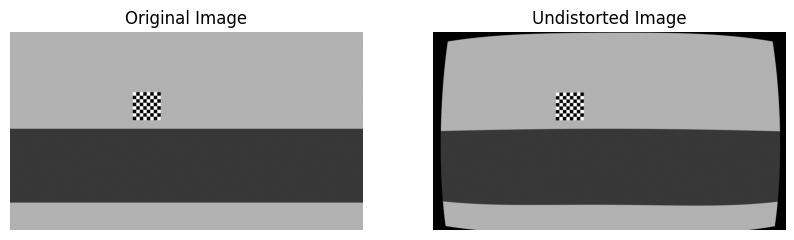

In [18]:
img = cv2.imread('./Calibration_Imgs/13.png')

# Undistort the image
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Undistorted image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.axis('off')

plt.show()

In [54]:
import scipy.optimize as sc_optimize

In [55]:
def f(x):
    print(x)
    return x**2 + 10*np.sin(x)

In [56]:
result = sc_optimize.minimize(f, x0=-2)
print(result)

[-2.]
[-1.99999999]
[-0.99]
[-0.98999999]
[-1.29355299]
[-1.29355297]
[-1.30711198]
[-1.30711197]
[-1.30643903]
[-1.30643902]
[-1.30644002]
[-1.30644]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -7.945823375615284
        x: [-1.306e+00]
      nit: 5
      jac: [ 5.960e-08]
 hess_inv: [[ 8.581e-02]]
     nfev: 12
     njev: 6
